# Imports

In [9]:
import os
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
from pathlib import Path
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

2025-05-09 03:43:13.062326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746762193.080255   14167 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746762193.085945   14167 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746762193.100242   14167 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746762193.100267   14167 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746762193.100269   14167 computation_placer.cc:177] computation placer alr

In [10]:
# Tensorflow Configuration
import multiprocessing

# Get the total number of CPU cores available
total_cores = multiprocessing.cpu_count()

# Calculate 75% of available cores (rounded down)
cores_to_use = int(total_cores * 0.90)

# Ensure at least 1 core is used
cores_to_use = max(1, cores_to_use)

# Set the environment variable
os.environ["LOKY_MAX_CPU_COUNT"] = str(cores_to_use)

print(f"Using {cores_to_use} out of {total_cores} available CPU cores (75%)")

# Add after TensorFlow import
tf.config.threading.set_inter_op_parallelism_threads(cores_to_use // 2)
tf.config.threading.set_intra_op_parallelism_threads(cores_to_use // 2)

Using 14 out of 16 available CPU cores (75%)


# Data Settings

In [11]:
# All bird species available in the HDF5 spectrogram dataset
ALL_BIRD_SPECIES = [
    'amecro',  # American Crow
    'amerob',  # American Robin
    'bewwre',  # Bewick's Wren
    'bkcchi',  # Black-capped Chickadee
    'daejun',  # Dark-eyed Junco
    'houfin',  # House Finch
    'houspa',  # House Sparrow
    'norfli',  # Northern Flicker
    'rewbla',  # Red-winged Blackbird
    'sonspa',  # Song Sparrow
    'spotow',  # Spotted Towhee
    'whcspa',  # White-crowned Sparrow
]

# Path to the HDF5 file containing bird spectrograms
SPEC_FILE_PATH = Path('../data/bird_spectrograms.hdf5')

# Training hyperparameters
EPOCHS = 50                 # Total number of training epochs
NUM_CV_FOLDS = 3            # K-Fold cross-validation (choose 3, 4, or 5)
BATCH_SIZE = [64, 128, 32]           # Batch size for training
LEARNING_RATE = [0.0005, 0.001]      # Learning rate for the optimizer

# List of evaluation metrics
EVALUATION_METRICS = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Load Data
We need to transpose the data from (128, 517, sample_size) into (sample_size, 128, 517) because CNNs expect an input of shape (N, C, H, W). 

Here:
- N = number of samples
- C = number of channels (1 for grayscale spectrograms)
- H = height (128)
- W = width (517)

In [12]:
X = []
y = []

num_classes = 0

with h5py.File(SPEC_FILE_PATH, 'r') as f:
    for label, key in enumerate(f.keys()):
        data = f[key][:]  # shape = (128, 517, N)
        data = np.transpose(data, (2, 0, 1))  # shape = (N, 128, 517)
        X.append(data)
        y.append(np.full((data.shape[0],), label, dtype=np.int32))
        num_classes += 1

X = np.concatenate(X, axis=0)  # (N_total, 128, 517)
y = np.concatenate(y)          # (N_total,)

X = np.expand_dims(X, axis=-1)  # (N_total, 128, 517, 1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(num_classes)

X shape: (1981, 128, 517, 1)
y shape: (1981,)
12


# CNN Model Model Architecture

This convolutional neural network (CNN) performs **binary classification** on spectrogram inputs of shape `(1, 128, 517)`, where:
- `1` is the channel dimension (grayscale),
- `128` is the number of frequency bins (height),
- `517` is the number of time steps (width).

---

### General Steps for CNN
According to a very long discussion on the order of layers, BN, DropOut, and Pooling on [stackoverflow](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) <br>
Generally, this laying is the consensus. <br>

Conv → BatchNorm → ReLU → Dropout → MaxPool


### Design
After global average pooling layer, I added in another dense layer with BN and dropout because I believe that this allows the model to learn interactions between features extracted by the CNN. Without this layer, the model directly maps pooled features to class probabilities which could limit some performance. The dataset itself isn't big, so I believed this would be a good enough approach.

# CNN Model #1

In [13]:
def build_bird_multi_cnn_v1(num_classes, input_shape=(128, 517, 1), dropout_rate=0.3, learning_rate=0.0005):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(128, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(512, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def build_bird_multi_cnn_v2(num_classes, input_shape=(128, 517, 1), dropout_rate=0.2, learning_rate=0.0001):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
    
    return model

# Graph Plotting

In [14]:
def build_plot_training_history(history, path, tag):
    """
    Plots training and validation accuracy and loss from two training histories.

    Args:
        history: First training history object.
        history2: Second training history object.
    """
    # Extract values from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{path}/{tag}_acc.png')
    plt.show()
    plt.close()

    # Plot Loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{path}/{tag}_loss.png')
    plt.show()
    plt.close()

def plot_cm(cm, path, tag):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f"Class {i}" for i in range(num_classes)],
                yticklabels=[f"Class {i}" for i in range(num_classes)])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f"{path}/{tag}_confusion_matrix.png")
    plt.close()

# Model Training and Evaluation Loop

For CNNs, these four essential steps are important. <br>
I have explained more about backpropagation in this [Medium article](https://medium.com/data-science-collective/why-backpropagation-is-so-important-for-models-in-machine-learning-4736591b24b3)

- Forward pass: Feed input through the network to make a prediction.
- Loss calculation: It compares those predictions to the actual labels and computes the loss.
- Backpropagation: Use the chain rule to find how much each weight influenced the loss.
- Weight update: Apply the gradients using an optimizer like Adam.
---

## Reasoning behind of KFold Cross Validation
Since the dataset is relatively small, it may be best to go with just a KFold Cross Validation rather than doing a train-test split + cross-validation. <br>

That is the reason why I went with K-fold cross validation.

---

# 5 Layer Model Run
- Batch Size = 64
- Dropout = 0.3
- Learning Rate = 0.0005
- 50 EPOCHS with early stopping.

Train class distribution: [ 53 137 115  36 100  67 504  30 149 210 110  73]
Test class distribution: [ 13  35  29   9  25  17 126   7  38  53  27  18]
(128, 517, 1)


2025-05-09 03:43:23.144215: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 252s 10s/step - accuracy: 0.2573 - loss: 2.3555 - val_accuracy: 0.1360 - val_loss: 2.3288 - learning_rate: 5.0000e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 245s 10s/step - accuracy: 0.3070 - loss: 2.2001 - val_accuracy: 0.1310 - val_loss: 2.4065 - learning_rate: 5.0000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 243s 10s/step - accuracy: 0.3261 - loss: 2.1492 - val_accuracy: 0.1436 - val_loss: 2.4572 - learning_rate: 5.0000e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 243s 10s/step - accuracy: 0.3128 - loss: 2.1671 - val_accuracy: 0.1486 - val_loss: 2.4023 - learning_rate: 5.0000e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 244s 10s/step - accuracy: 0.3116 - loss: 2.1181 - val_accuracy: 0.2343 - val_loss: 2.3122 - learning_rate: 5.0000e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 242s 10s/step - accuracy: 0.3528 - loss: 2.0296 - val_accuracy: 0.3149 - val_loss: 3.6149 - learning_rate: 5.0000e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 242s 10s/step - accuracy: 

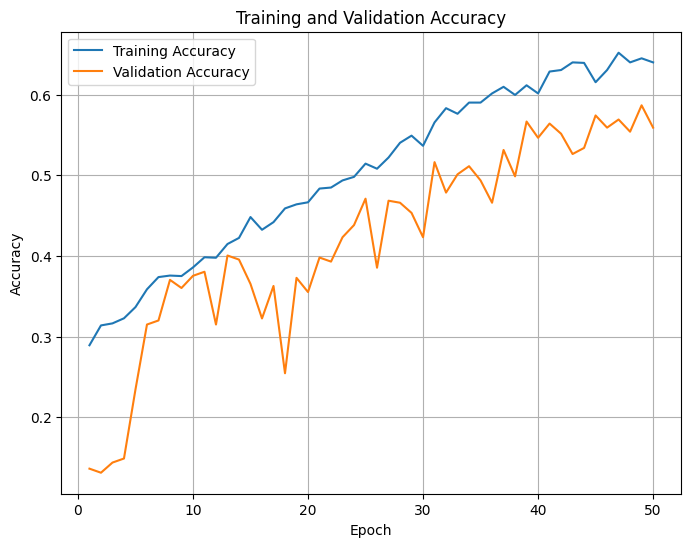

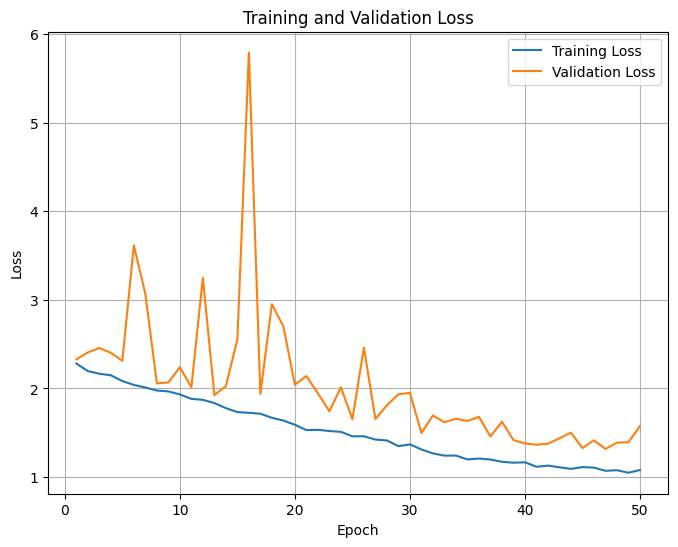

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Confusion Matrix:
 [[  9   0   0   0   0   0   2   0   1   1   0   0]
 [  0  13   0   0   0   1   5   0   8   3   2   3]
 [  1   2   4   0   2   0   2   0   2  11   5   0]
 [  0   1   0   0   0   0   3   0   4   1   0   0]
 [  3   1   0   0  13   0   2   0   0   2   2   2]
 [  0   3   1   0   1   3   0   0   4   5   0   0]
 [  2   1   0   0   0   0 115   0   4   1   3   0]
 [  1   0   0   0   1   0   0   0   4   1   0   0]
 [  1   2   0   0   1   0   5   0  19   4   5   1]
 [  1   2   3   0   2   0   5   0   4  33   2   1]
 [  0   0   0   0   0   0   5   0   5   4  13   0]
 [  0   1   0   0   3   0   1   0   2   6   1   4]]
Confusion matrix saved to ../output/multi-class_results/5_layer_best_model_results_confusion_matrix.csv


/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.6923    0.5806        13
           1     0.5000    0.3714    0.4262        35
           2     0.5000    0.1379    0.2162        29
           3     0.0000    0.0000    0.0000         9
           4     0.5652    0.5200    0.5417        25
           5     0.7500    0.1765    0.2857        17
           6     0.7931    0.9127    0.8487       126
           7     0.0000    0.0000    0.0000         7
           8     0.3333    0.5000    0.4000        38
           9     0.4583    0.6226    0.5280        53
          10     0.3939    0.4815    0.4333        27
          11     0.3636    0.2222    0.2759        18

    accuracy                         0.5693       397
   macro avg     0.4298    0.3864    0.3780       397
weighted avg     0.5528    0.5693    0.5388       397



,accuracy,precision_macro,recall_macro,f1_macro
5_layer_best_model_results,0.56927,0.429797,0.386432,0.378031


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, shuffle=True
)

print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))
print(X_train.shape[1:])
# Initialize model
model = build_bird_multi_cnn_v1(num_classes=num_classes, input_shape=X_train.shape[1:], dropout_rate=0.3, learning_rate=0.0005)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train
history_5layer = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualize training history (optional)
result_path = "../output/multi-class_results"
run_tag = f"5_layer_best_model_results"
build_plot_training_history(history_5layer, result_path, run_tag)

# Evaluate
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = y_test.flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Save raw confusion matrix values
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(num_classes)],
                         columns=[f"Predicted_{i}" for i in range(num_classes)])

cm_csv_path = f"{result_path}/{run_tag}_confusion_matrix.csv"
cm_df.to_csv(cm_csv_path)
print(f"Confusion matrix saved to {cm_csv_path}")

plot_cm(cm, result_path, run_tag)

# Classification Report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Save results
metrics = pd.DataFrame(columns=EVALUATION_METRICS)
metrics.loc[run_tag] = [acc, prec, rec, f1]

# Cleanup
K.clear_session()
del model
gc.collect()

display(metrics)

# 4 Layer Model Run
- Batch Size = 32
- Dropout = 0.2
- Learning Rate = 0.0005
- 50 EPOCHS with early stopping.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, shuffle=True
)

print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))
print(X_train.shape[1:])
# Initialize model
model = build_bird_multi_cnn_v2(num_classes=num_classes, input_shape=X_train.shape[1:], dropout_rate=0.2, learning_rate=0.0005)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train
history_4layer = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualize training history (optional)
result_path = "../output/multi-class_results"
run_tag = f"4_layer_best_model_results"
build_plot_training_history(history_4layer, result_path, run_tag)

# Evaluate
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = y_test.flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Save raw confusion matrix values
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(num_classes)],
                         columns=[f"Predicted_{i}" for i in range(num_classes)])

cm_csv_path = f"{result_path}/{run_tag}_confusion_matrix.csv"
cm_df.to_csv(cm_csv_path)
print(f"Confusion matrix saved to {cm_csv_path}")

plot_cm(cm, result_path, run_tag)

# Classification Report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Save results
metrics = pd.DataFrame(columns=EVALUATION_METRICS)
metrics.loc[run_tag] = [acc, prec, rec, f1]

# Cleanup
K.clear_session()
del model
gc.collect()

display(metrics)

Train class distribution: [ 53 137 115  36 100  67 504  30 149 210 110  73]
Test class distribution: [ 13  35  29   9  25  17 126   7  38  53  27  18]
(128, 517, 1)
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.1121 - loss: 2.8666 - val_accuracy: 0.0277 - val_loss: 2.9222 - learning_rate: 5.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.2289 - loss: 2.4347 - val_accuracy: 0.2922 - val_loss: 2.3608 - learning_rate: 5.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.2845 - loss: 2.2749 - val_accuracy: 0.3275 - val_loss: 2.1969 - learning_rate: 5.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.3026 - loss: 2.1516 - val_accuracy: 0.3451 - val_loss: 2.1694 - learning_rate: 5.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3746 - loss: 2.0092 - val_accuracy: 0.3375 - val_loss: 2.2561 - learning_rate: 5.0000e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accurac

# 5 Layer Model Run (Longer Epochs)

- Batch Size = 64
- Dropout = 0.3
- Learning Rate = 0.0005
- 300 EPOCHS with early stopping.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, shuffle=True
)

print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))
print(X_train.shape[1:])
# Initialize model
model = build_bird_multi_cnn_v1(num_classes=num_classes, input_shape=X_train.shape[1:], dropout_rate=0.3, learning_rate=0.0005)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train
history_5layer = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=300,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualize training history (optional)
result_path = "../output/multi-class_results"
run_tag = f"5_layer_longer_epochs_best_model_results"
build_plot_training_history(history_5layer, result_path, run_tag)
model.save(f'{result_path}/{run_tag}.keras')

# Evaluate
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = y_test.flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Save raw confusion matrix values
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(num_classes)],
                         columns=[f"Predicted_{i}" for i in range(num_classes)])

cm_csv_path = f"{result_path}/{run_tag}_confusion_matrix.csv"
cm_df.to_csv(cm_csv_path)
print(f"Confusion matrix saved to {cm_csv_path}")

plot_cm(cm, result_path, run_tag)

# Classification Report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Save results
metrics = pd.DataFrame(columns=EVALUATION_METRICS)
metrics.loc[run_tag] = [acc, prec, rec, f1]

# Cleanup
K.clear_session()
del model
gc.collect()

display(metrics)